In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

In [2]:
path = "../data/online_retail_II.csv"
df = pd.read_csv(path, sep="," , encoding='latin-1')
df.head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom


In [3]:
print("📊 REPORTE DE CALIDAD DE DATOS")
pd.options.display.float_format = '{:,.2f}'.format
print("="*40)
# 1. Dimensiones Básicas

print(f"📐 Dimensiones totales:")
print(f"   - Filas:    {df.shape[0]:,}")
print(f"   - Columnas: {df.shape[1]}")
# 2. Tipos de Datos y Nombres de Columnas

print("\n📋 Tipos de datos por columna:")
print(df.dtypes)
# 3. Identificación de Valores Nulos (Vacíos)

nulos = df.isnull().sum()
nulos_pct = (df.isnull().sum() / len(df)) * 100
print("\n❌ Valores Nulos (Cantidad y Porcentaje):")
print(pd.concat([nulos, nulos_pct], axis=1, keys=['Cantidad', '% Nulos']).sort_values('Cantidad', ascending=False))
# 4. Identificación de Duplicados

duplicados = df.duplicated().sum()
print(f"\nFilas totalmente duplicadas: {duplicados:,} ({(duplicados/len(df))*100:.2f}%)")
# 5. Resumen Estadístico Básico (Para detectar anomalías numéricas)

print("\n📈 Estadísticas rápidas (Ojo a los negativos en 'Min'):")
display(df.describe())

📊 REPORTE DE CALIDAD DE DATOS
📐 Dimensiones totales:
   - Filas:    1,067,371
   - Columnas: 8

📋 Tipos de datos por columna:
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

❌ Valores Nulos (Cantidad y Porcentaje):
             Cantidad  % Nulos
Customer ID    243007    22.77
Description      4382     0.41
StockCode           0     0.00
Invoice             0     0.00
Quantity            0     0.00
InvoiceDate         0     0.00
Price               0     0.00
Country             0     0.00

Filas totalmente duplicadas: 34,335 (3.22%)

📈 Estadísticas rápidas (Ojo a los negativos en 'Min'):


,Quantity,Price,Customer ID
count,"1,067,371.00","1,067,371.00","824,364.00"
mean,9.94,4.65,"15,324.64"
std,172.71,123.55,"1,697.46"
min,"-80,995.00","-53,594.36","12,346.00"
25%,1.00,1.25,"13,975.00"
50%,3.00,2.10,"15,255.00"
75%,10.00,4.15,"16,797.00"
max,"80,995.00","38,970.00","18,287.00"


In [4]:
# Limpieza
df_clean = df.copy()
codigos_extraños = ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'C2']
df_clean = df_clean[~df_clean['StockCode'].isin(codigos_extraños)]
df_clean = df_clean.dropna(subset=['Customer ID'])
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']
df_clean.head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,"13,085.00",United Kingdom,83.40


In [5]:
df_clean.describe()

,Quantity,InvoiceDate,Price,Customer ID,TotalAmount
count,"802,679.00",802679,"802,679.00","802,679.00","802,679.00"
mean,13.32,2011-01-02 08:58:01.201900544,2.94,"15,338.10",21.73
min,1.00,2009-12-01 07:45:00,0.03,"12,346.00",0.06
25%,2.00,2010-07-07 11:53:00,1.25,"13,988.00",4.95
50%,5.00,2010-12-03 14:54:00,1.95,"15,276.00",11.80
75%,12.00,2011-07-28 13:02:00,3.75,"16,809.00",19.50
max,"80,995.00",2011-12-09 12:50:00,649.50,"18,287.00","168,469.60"
std,143.86,NaN,4.40,"1,693.94",222.57


In [19]:
df_raw=df_clean.copy()
df_raw['Hour_Num'] = df_raw['InvoiceDate'].dt.hour
df_raw['InvoiceDate'] = df_raw['InvoiceDate'].dt.strftime('%d-%m-%Y')
df_raw['Hour'] = df_raw['Hour_Num'].apply(lambda x: f"{x:02d}:00 - {x+1:02d}:00")
df_raw['Day_time'] = df_raw['Hour_Num'].apply(lambda x: '(1) Morning' if 6 <= x < 12 else ('(2) Afternoon' if 12 <= x < 18 else '(3) Nigth'))
df_raw.head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount,Hour_Num,Hour,Day_time
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01-12-2009,6.95,"13,085.00",United Kingdom,83.40,7,07:00 - 08:00,(1) Morning


In [7]:
fact = df_raw.groupby(['StockCode','Description','InvoiceDate','Country','Price','Day_time']).agg({
    'TotalAmount': 'sum',  # Total gastado en esa factura
    'Quantity': 'sum',     # Total de artículos en la canasta
    'Invoice': 'count'
    }).reset_index()

fact.head(1)

,StockCode,Description,InvoiceDate,Country,Price,Day_time,TotalAmount,Quantity,Invoice
0,10002,INFLATABLE POLITICAL GLOBE,01-02-2010,United Kingdom,0.85,(1) Morning,2.55,3,1


In [8]:
fact.describe()

,Price,TotalAmount,Quantity,Invoice
count,"586,263.00","586,263.00","586,263.00","586,263.00"
mean,2.99,29.75,18.24,1.37
std,4.76,263.31,169.65,0.90
min,0.03,0.06,1.00,1.00
25%,1.25,6.60,3.00,1.00
50%,1.95,15.00,7.00,1.00
75%,3.75,26.25,15.00,1.00
max,649.50,"168,469.60","80,995.00",36.00


In [15]:
fact.to_csv('../data/fact.csv', sep='|', encoding='latin1', index=False)
df_raw.to_csv('../data/data_raw.csv',sep='|', encoding='latin1', index=False)

In [20]:
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'], dayfirst=True)

In [22]:
# Renombrar columnas para que coincidan con el código estándar
df_raw.rename(columns={
    'Customer ID':'CustomerID',
    'Invoice': 'InvoiceNo',  # Cambiamos Invoice -> InvoiceNo
    'Price': 'UnitPrice'     # Cambiamos Price -> UnitPrice (por si acaso)
}, inplace=True)


C:\Users\jsgon\AppData\Local\Temp\ipykernel_19852\1982661340.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
C:\Users\jsgon\AppData\Local\Temp\ipykernel_19852\1982661340.py:51: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(save_path, 'rfm_segments.png'), bbox_inches='tight')
C:\Users\jsgon\AppData\Local\Temp\ipykernel_19852\1982661340.py:51: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(save_path, 'rfm_segments.png'), bbox_inches='tight')
C:\Users\jsgon\AppData\Local\Temp\ipykernel_19852\1982661340.py:51: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(save_path, 'rfm_segments.png'), b

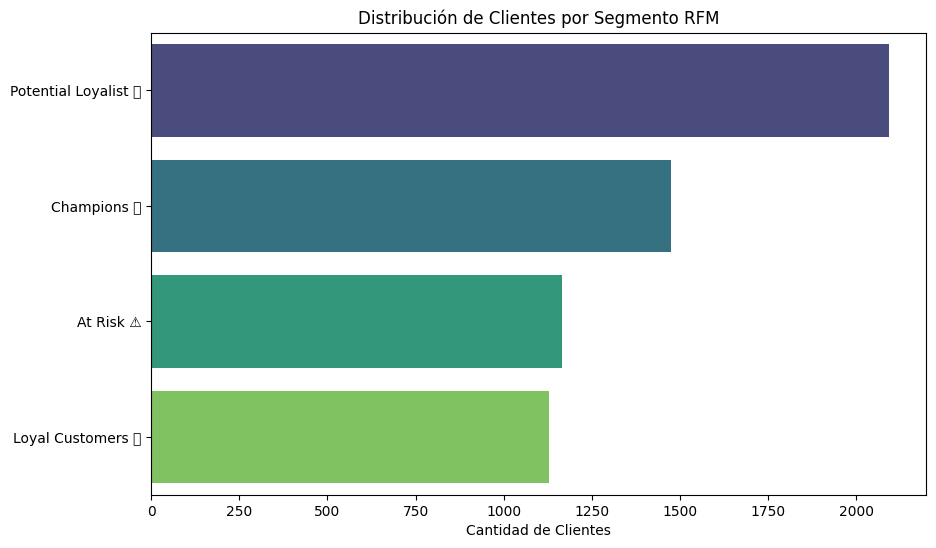

In [26]:
# Definir fecha de referencia (1 día después de la última venta)
snapshot_date = df_raw['InvoiceDate'].max() + dt.timedelta(days=1)

# Calcular métricas RFM
rfm = df_raw.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                   # Frequency
    'TotalAmount': 'sum'                                    # Monetary
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

# Crear puntajes (1 a 5) usando cuartiles
labels = range(1, 6)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=list(reversed(labels))) # Recency: menor es mejor (5)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=labels)

# Crear Segmentos (Combinación de R y F)
def segment_customer(row):
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    
    if r >= 4 and f >= 4: return "Champions 🏆"
    elif r >= 3 and f >= 3: return "Loyal Customers 💎"
    elif r >= 2 and f >= 1: return "Potential Loyalist 🌱"
    elif r <= 1: return "At Risk ⚠️"
    else: return "Standard"

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# --- GRÁFICO 1: Distribución de Segmentos ---
save_path = '../images'

# 2. Crear la carpeta si no existe (esto evita el error FileNotFoundError)
if not os.path.exists(save_path):
    os.makedirs(save_path)

# --- GRÁFICO 1: Distribución de Segmentos ---
plt.figure(figsize=(10, 6))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Distribución de Clientes por Segmento RFM')
plt.xlabel('Cantidad de Clientes')
plt.ylabel('')

# 3. Guardar usando la ruta corregida
plt.savefig(os.path.join(save_path, 'rfm_segments.png'), bbox_inches='tight')
plt.show()

C:\Users\jsgon\AppData\Local\Temp\ipykernel_19852\1094349365.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalAmount', y='Class', data=product_sales, estimator=sum, palette='magma')


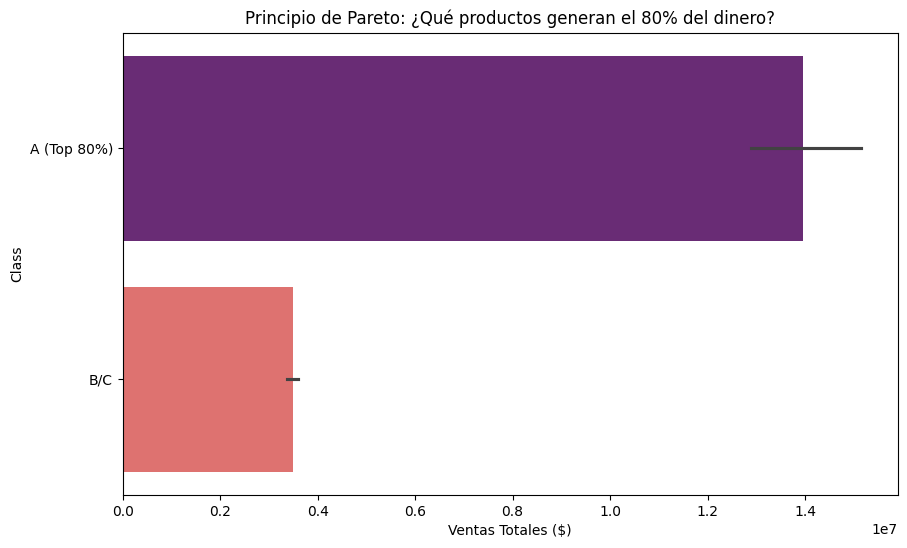

In [27]:
# Definir ruta de guardado segura
save_path = '../images'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# --- ANÁLISIS PARETO (ABC) ---
# 1. Agrupar por producto y sumar ventas
product_sales = df_raw.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).reset_index()

# 2. Calcular acumulados
product_sales['Cumulative'] = product_sales['TotalAmount'].cumsum()
product_sales['Total_Sum'] = product_sales['TotalAmount'].sum()

# 3. Clasificar A, B, C (A = el 80% de tus ingresos)
product_sales['Class'] = product_sales['Cumulative'].apply(lambda x: 'A (Top 80%)' if x/product_sales['Total_Sum'].max() <= 0.8 else 'B/C')

# 4. Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='TotalAmount', y='Class', data=product_sales, estimator=sum, palette='magma')
plt.title('Principio de Pareto: ¿Qué productos generan el 80% del dinero?')
plt.xlabel('Ventas Totales ($)')

# 5. Guardar
plt.savefig(os.path.join(save_path, 'pareto_abc.png'), bbox_inches='tight')
plt.show()

In [28]:
productos_top = product_sales[product_sales['Class'] == 'A (Top 80%)']

# 2. Ordenarlos por ventas (del más vendido al menos vendido)
productos_top = productos_top.sort_values(by='TotalAmount', ascending=False)

# 3. Mostrar los 10 mejores en pantalla
print("--- TOP 10 PRODUCTOS ESTRELLA (CLASE A) ---")
print(productos_top[['Description', 'TotalAmount']].head(10))

--- TOP 10 PRODUCTOS ESTRELLA (CLASE A) ---
                          Description  TotalAmount
0            REGENCY CAKESTAND 3 TIER   286,486.30
1  WHITE HANGING HEART T-LIGHT HOLDER   252,072.46
2         PAPER CRAFT , LITTLE BIRDIE   168,469.60
3             JUMBO BAG RED RETROSPOT   136,980.08
4       ASSORTED COLOUR BIRD ORNAMENT   127,074.17
5                       PARTY BUNTING   103,880.23
6      MEDIUM CERAMIC TOP STORAGE JAR    81,416.73
7     PAPER CHAIN KIT 50'S CHRISTMAS     79,594.33
8                       CHILLI LIGHTS    72,860.14
9            BLACK RECORD COVER FRAME    67,209.44
